## Predicting real part of dielectric function with GNNOpt from crystal structures

### Getting started

In [1]:
import os
import sys
# Get the absolute path of the current notebook's directory
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(parent_dir)  # Add parent directory to sys.path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn.io import CartesianTensor
from e3nn import o3
from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from scipy.interpolate import interp1d

# supress error log from font
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

# utilities
import time
from mendeleev import element
from tqdm import tqdm
from utils.utils_data import (load_data, train_valid_test_split, save_or_load_onehot, build_data, plot_predictions, weighted_mean, r2_score
                               ,plot_spherical_harmonics_comparison, plot_cartesian_tensor_comparison)
from utils.utils_model import Network, visualize_layers, train

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])

# Check device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)

torch device: cuda:0


In [2]:
data_file = '../dataset/symmetrized_dataset.pkl'
df, species = load_data(data_file)
df.head()

,formula,symmetrized_structure,mp_id,bandgap,crystal_system,omega,species,real_symmetrized_permittivity,imag_symmetrized_permittivity
0,Li4Se8Y4,"(Atom('Li', [2.8385500000000006, 0.0, 2.88335]...",mp-37879,1.6604,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Y, Se, Li]","[[[3.4812758467294405, 0.0, -2.584939414228211...","[[[-1.2523566768095863e-17, 0.0, -4.8148248609..."
1,Mo3S2Se4,"(Atom('Mo', [1.6365999999999998, 0.94489145055...",mp-1025906,0.5619,trigonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Mo, Se, S]","[[[5.124538605076387, 6.794333614242494e-18, 5...","[[[2.6245939830145304e-17, -2.5679065925163146..."
2,Li3NbS4,"(Atom('Li', [0.0, 0.0, 3.0251], index=0), Atom...",mp-755309,2.8348,cubic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Nb, Li, S]","[[[1.7313150452437125, -3.529303946892918e-23,...","[[[9.73175816465002e-19, 0.0, 0.0], [0.0, 9.73..."
3,CdSe2Zn,"(Atom('Zn', [2.07525, 2.07525, 2.981], index=0...",mp-1017534,0.7236,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Se, Zn, Cd]","[[[3.2667200732203123, 0.0, 0.0], [0.0, 3.2667...","[[[-8.841535879698145e-18, 0.0, -9.62964972193..."
4,Al8Te12,"(Atom('Al', [-1.0110162555088607, 0.7063003620...",mp-1228524,1.3222,monoclinic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Al, Te]","[[[3.57865600493003, 0.0, 0.0588499476841695],...","[[[-2.370171074423322e-18, 0.0, 3.360404376639..."


### Reconstruction data

In [3]:
energy_min = 0
energy_max = 30
nstep = 300
new_x = np.linspace(energy_min, energy_max, nstep)

def interpolate_matrix(matrix, omega):
    interp = interp1d(omega, matrix, kind='linear', axis=0, fill_value=0, bounds_error=False)
    return interp(new_x)

df['imag_Permittivity_Matrices_interp'] = [
    interpolate_matrix(row['imag_symmetrized_permittivity'], row['omega']) for _, row in df.iterrows()
]
df['energies_interp'] = df.apply(lambda x: new_x, axis=1)

stack_matrices_tensor = torch.tensor(np.stack(df['imag_Permittivity_Matrices_interp'].values), dtype=torch.float64)
x = CartesianTensor("ij=ji")
sph_coefs_tensor = x.from_cartesian(stack_matrices_tensor)
df['sph_coefs'] = list(sph_coefs_tensor.numpy())

type_onehot, mass_onehot, dipole_onehot, radius_onehot, type_encoding = save_or_load_onehot()

tmp = np.array([df.iloc[i]['sph_coefs'] for i in range(len(df))])
scale_data = np.median(np.max(np.abs(tmp), axis=(1, 2)))

r_max = 6.
df['data'] = df.progress_apply(lambda x: build_data(x, 'sph_coefs', scale_data,
                                                    type_onehot, mass_onehot, dipole_onehot,
                                                    radius_onehot, type_encoding, r_max), axis=1)


Loading existing data...


  2%|▏         | 32/1432 [00:00<00:14, 93.37it/s] 

100%|██████████| 1432/1432 [00:24<00:00, 59.05it/s]


In [4]:
run_time = time.strftime('%y%m%d', time.localtime())
idx_train, idx_valid, idx_test = train_valid_test_split(df, valid_size=.1, test_size=.1, plot=False)
np.savetxt('../model/idx_train_'+ run_time +'.txt', idx_train, fmt='%i', delimiter='\t')
np.savetxt('../model/idx_valid_'+ run_time +'.txt', idx_valid, fmt='%i', delimiter='\t')
np.savetxt('../model/idx_test_'+ run_time +'.txt', idx_test, fmt='%i', delimiter='\t')


Unique crystal systems found: ['tetragonal', 'trigonal', 'cubic', 'monoclinic', 'hexagonal', 'triclinic', 'orthorhombic']
Splitting train/dev ...
Splitting valid/test ...
Number of training examples: 1142
Number of validation examples: 143
Number of testing examples: 147
Total number of examples: 1432


For use with the trained model provided, the indices of the training, validation, and test sets are loaded below. These indices were generated with a specific seed using the above `train_valid_test_split` function.

In [5]:
# load train/valid/test indices
with open('../model/idx_train_'+run_time+'.txt', 'r') as f: idx_train = [int(i.split('\n')[0]) for i in f.readlines()]
with open('../model/idx_valid_'+run_time+'.txt', 'r') as f: idx_valid = [int(i.split('\n')[0]) for i in f.readlines()]
with open('../model/idx_test_'+run_time+'.txt', 'r') as f: idx_test = [int(i.split('\n')[0]) for i in f.readlines()]

# format dataloaders
batch_size = 4
dataloader_train = tg.loader.DataLoader(df.iloc[idx_train]['data'].values, batch_size=batch_size, shuffle=True)
dataloader_valid = tg.loader.DataLoader(df.iloc[idx_valid]['data'].values, batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(df.iloc[idx_test]['data'].values, batch_size=batch_size)

In [7]:
def get_neighbors(df, idx):
    n = []
    for entry in df.iloc[idx].itertuples():
        N = entry.data.pos.shape[0]
        for i in range(N):
            n.append(len((entry.data.edge_index[0] == i).nonzero()))
    return np.array(n)
n_train = get_neighbors(df, idx_train)
n_valid = get_neighbors(df, idx_valid)
n_test = get_neighbors(df, idx_test)


### Network architecture
We build a model based on the `Network` described in the `e3nn` [Documentation](https://docs.e3nn.org/en/latest/api/nn/models/gate_points_2101.html), modified to incorporate the periodic boundaries we imposed on the crystal graphs. The network applies equivariant convolutions to each atomic node and finally takes an average over all nodes, normalizing the output.

In [8]:
class PeriodicNetwork(Network):
    def __init__(self, in_dim, em_dim, **kwargs):            
        # override the `reduce_output` keyword to instead perform an averge over atom contributions    
        self.pool = False
        if kwargs['reduce_output'] == True:
            kwargs['reduce_output'] = False
            self.pool = True
            
        super().__init__(**kwargs)

        self.em_z = nn.Linear(in_dim, em_dim)    #Linear layer for atom type
        self.em_x = nn.Linear(in_dim, em_dim)    #Linear layer for atom type

    def forward(self, data: Union[tg.data.Data, Dict[str, torch.Tensor]]) -> torch.Tensor:
        data.z = F.relu(self.em_z(data.z))
        data.x = F.relu(self.em_x(data.x))

        output = super().forward(data)
        ### RELU issue, from e3nn discussion, removing because it might break the symmetry
        #output = torch.relu(output)
        
        # if pool_nodes was set to True, use scatter_mean to aggregate
        if self.pool == True:
            output = torch_scatter.scatter_mean(output, data.batch, dim=0)  # take mean over atoms per example
        return output

out_dim = len(df.iloc[0]['energies_interp']) 
em_dim = 64


use_batch_norm = False
dropout_prob=0.4

model = PeriodicNetwork(
    in_dim=118,
    em_dim=em_dim,
    irreps_in=str(em_dim)+"x0e",
    irreps_out=str(6 * out_dim)+"x0e",
    irreps_node_attr=str(em_dim)+"x0e",
    layers=2,
    mul=32,
    lmax=2,
    max_radius=r_max,
    num_neighbors=n_train.mean(),
    reduce_output=True,
)
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Trainable parameters: 18,903,864


### Training
The model is trained using a mean-squared error loss function with an Adam optimizer.

In [9]:
opt = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.05)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.96)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    opt,
    T_0=10, T_mult=1,
    eta_min=0     # Minimum learning rate (optional, default is 0)
)

#loss_fn = torch.nn.HuberLoss()
loss_fn = torch.nn.MSELoss()
loss_fn_mae = torch.nn.L1Loss()

In [10]:
run_name = 'model_eps1_' + run_time
model.pool = True
train(model, opt, dataloader_train, dataloader_valid, loss_fn, loss_fn_mae, run_name, 
       max_iter=100, scheduler=scheduler, device=device)

  0%|          | 1/286 [00:00<03:25,  1.39it/s]

100%|██████████| 286/286 [00:09<00:00, 31.52it/s]


New best validation loss: 0.0060. Saving model...
Iteration    1   train loss =   0.0070   valid loss =   0.0060   elapsed time = 00:00:09


100%|██████████| 286/286 [00:07<00:00, 37.09it/s]


New best validation loss: 0.0050. Saving model...
Iteration    2   train loss =   0.0059   valid loss =   0.0050   elapsed time = 00:00:20


100%|██████████| 286/286 [00:08<00:00, 35.68it/s]


New best validation loss: 0.0048. Saving model...
Iteration    3   train loss =   0.0053   valid loss =   0.0048   elapsed time = 00:00:31


100%|██████████| 286/286 [00:07<00:00, 35.99it/s]


New best validation loss: 0.0043. Saving model...
Iteration    4   train loss =   0.0047   valid loss =   0.0043   elapsed time = 00:00:42


100%|██████████| 286/286 [00:07<00:00, 36.29it/s]


New best validation loss: 0.0039. Saving model...
Iteration    5   train loss =   0.0042   valid loss =   0.0039   elapsed time = 00:00:53


100%|██████████| 286/286 [00:07<00:00, 37.39it/s]


New best validation loss: 0.0035. Saving model...
Iteration    7   train loss =   0.0035   valid loss =   0.0035   elapsed time = 00:01:11


100%|██████████| 286/286 [00:07<00:00, 38.16it/s]


New best validation loss: 0.0034. Saving model...
Iteration    9   train loss =   0.0031   valid loss =   0.0034   elapsed time = 00:01:29


100%|██████████| 286/286 [00:08<00:00, 34.11it/s]


Iteration   11   train loss =   0.0044   valid loss =   0.0044   elapsed time = 00:01:50


100%|██████████| 286/286 [00:07<00:00, 38.45it/s]


Iteration   14   train loss =   0.0038   valid loss =   0.0043   elapsed time = 00:02:16


100%|██████████| 286/286 [00:08<00:00, 35.16it/s]


New best validation loss: 0.0034. Saving model...
Iteration   17   train loss =   0.0025   valid loss =   0.0034   elapsed time = 00:02:44


100%|██████████| 286/286 [00:07<00:00, 38.18it/s]


Iteration   21   train loss =   0.0039   valid loss =   0.0038   elapsed time = 00:03:19


100%|██████████| 286/286 [00:09<00:00, 30.26it/s]


Iteration   25   train loss =   0.0025   valid loss =   0.0036   elapsed time = 00:03:55


100%|██████████| 286/286 [00:08<00:00, 32.17it/s]


New best validation loss: 0.0032. Saving model...
Iteration   29   train loss =   0.0015   valid loss =   0.0032   elapsed time = 00:04:35


100%|██████████| 286/286 [00:09<00:00, 29.87it/s]


Iteration   34   train loss =   0.0038   valid loss =   0.0040   elapsed time = 00:05:22


100%|██████████| 286/286 [00:08<00:00, 33.73it/s]


New best validation loss: 0.0030. Saving model...
Iteration   39   train loss =   0.0011   valid loss =   0.0030   elapsed time = 00:06:08


100%|██████████| 286/286 [00:07<00:00, 39.82it/s]


Iteration   44   train loss =   0.0019   valid loss =   0.0031   elapsed time = 00:06:50


100%|██████████| 286/286 [00:08<00:00, 32.44it/s]


New best validation loss: 0.0027. Saving model...
Iteration   49   train loss =   0.0009   valid loss =   0.0027   elapsed time = 00:07:36


100%|██████████| 286/286 [00:10<00:00, 26.19it/s]


Iteration   54   train loss =   0.0024   valid loss =   0.0031   elapsed time = 00:08:27


100%|██████████| 286/286 [00:10<00:00, 28.17it/s]


Iteration   59   train loss =   0.0011   valid loss =   0.0033   elapsed time = 00:09:27


100%|██████████| 286/286 [00:09<00:00, 29.80it/s]


Iteration   64   train loss =   0.0018   valid loss =   0.0033   elapsed time = 00:10:16


100%|██████████| 286/286 [00:07<00:00, 36.92it/s]


Iteration   69   train loss =   0.0008   valid loss =   0.0034   elapsed time = 00:10:59


100%|██████████| 286/286 [00:07<00:00, 36.72it/s]


Iteration   74   train loss =   0.0019   valid loss =   0.0032   elapsed time = 00:11:40


100%|██████████| 286/286 [00:09<00:00, 29.13it/s]


Iteration   79   train loss =   0.0007   valid loss =   0.0029   elapsed time = 00:12:28


100%|██████████| 286/286 [00:09<00:00, 31.36it/s]


Iteration   84   train loss =   0.0018   valid loss =   0.0031   elapsed time = 00:13:14


100%|██████████| 286/286 [00:09<00:00, 31.37it/s]


Iteration   89   train loss =   0.0006   valid loss =   0.0032   elapsed time = 00:14:03


100%|██████████| 286/286 [00:07<00:00, 36.35it/s]


Iteration   94   train loss =   0.0016   valid loss =   0.0030   elapsed time = 00:14:46


100%|██████████| 286/286 [00:07<00:00, 36.56it/s]


Iteration   99   train loss =   0.0007   valid loss =   0.0028   elapsed time = 00:15:28


100%|██████████| 286/286 [00:07<00:00, 37.04it/s]


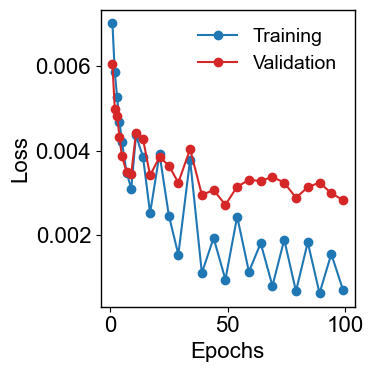

In [11]:
# load pre-trained model and plot its training history
#run_name = 'model_alpha_mass_' + run_time
history = torch.load('../model/' + run_name + '.torch', map_location=device)['history']
steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

np.savetxt(run_name+'_MSE_loss.txt', np.column_stack((steps, loss_train, loss_valid)), fmt='%.8f', delimiter='\t')

fig, ax = plt.subplots(figsize=(4,4))
ax.plot(steps, loss_train, 'o-', label="Training", color='C0')
ax.plot(steps, loss_valid, 'o-', label="Validation", color='C3')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(frameon=False)
plt.tight_layout()
# fig.savefig(run_name + '_loss.pdf')

### Results
We evaluate our model by visualizing the predicted and true optical spectra in each error quartile.

In [12]:
# predict on all data
model.load_state_dict(torch.load('../model/'+run_name + '.torch', map_location=device)['state'])
model.pool = True

dataloader = tg.loader.DataLoader(df['data'].values, batch_size=64)
df['mse'] = 0.
df['y_pred_sph'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()

# weight contribution of each feature
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        y_reordered = d.y.permute(0, 2, 1)   # [batch_size, 6, 300]
        y_unrolled = y_reordered.reshape(d.y.size(0), -1)  # [batch_size, 1800]
        output_reshaped = output.view(-1, 6, 300).permute(0, 2, 1)  # → [batch_size, 300, 6]
        loss = F.mse_loss(output, y_unrolled, reduction='none').mean(dim=-1).cpu().numpy() 
        df.loc[i0:i0 + len(d.y) - 1, 'y_pred_sph'] = [[k] for k in output_reshaped.cpu().numpy()]
        # df.loc[i0:i0 + len(d.y) - 1, 'y_pred_sph'] = [out.cpu().numpy() for out in output_reshaped]
        df.loc[i0:i0 + len(d.y) - 1, 'mse'] = loss
        i0 += len(d.y)
        
df['y_pred_sph'] = df['y_pred_sph'].map(lambda x: x[0])*scale_data

100%|██████████| 23/23 [00:01<00:00, 16.33it/s]


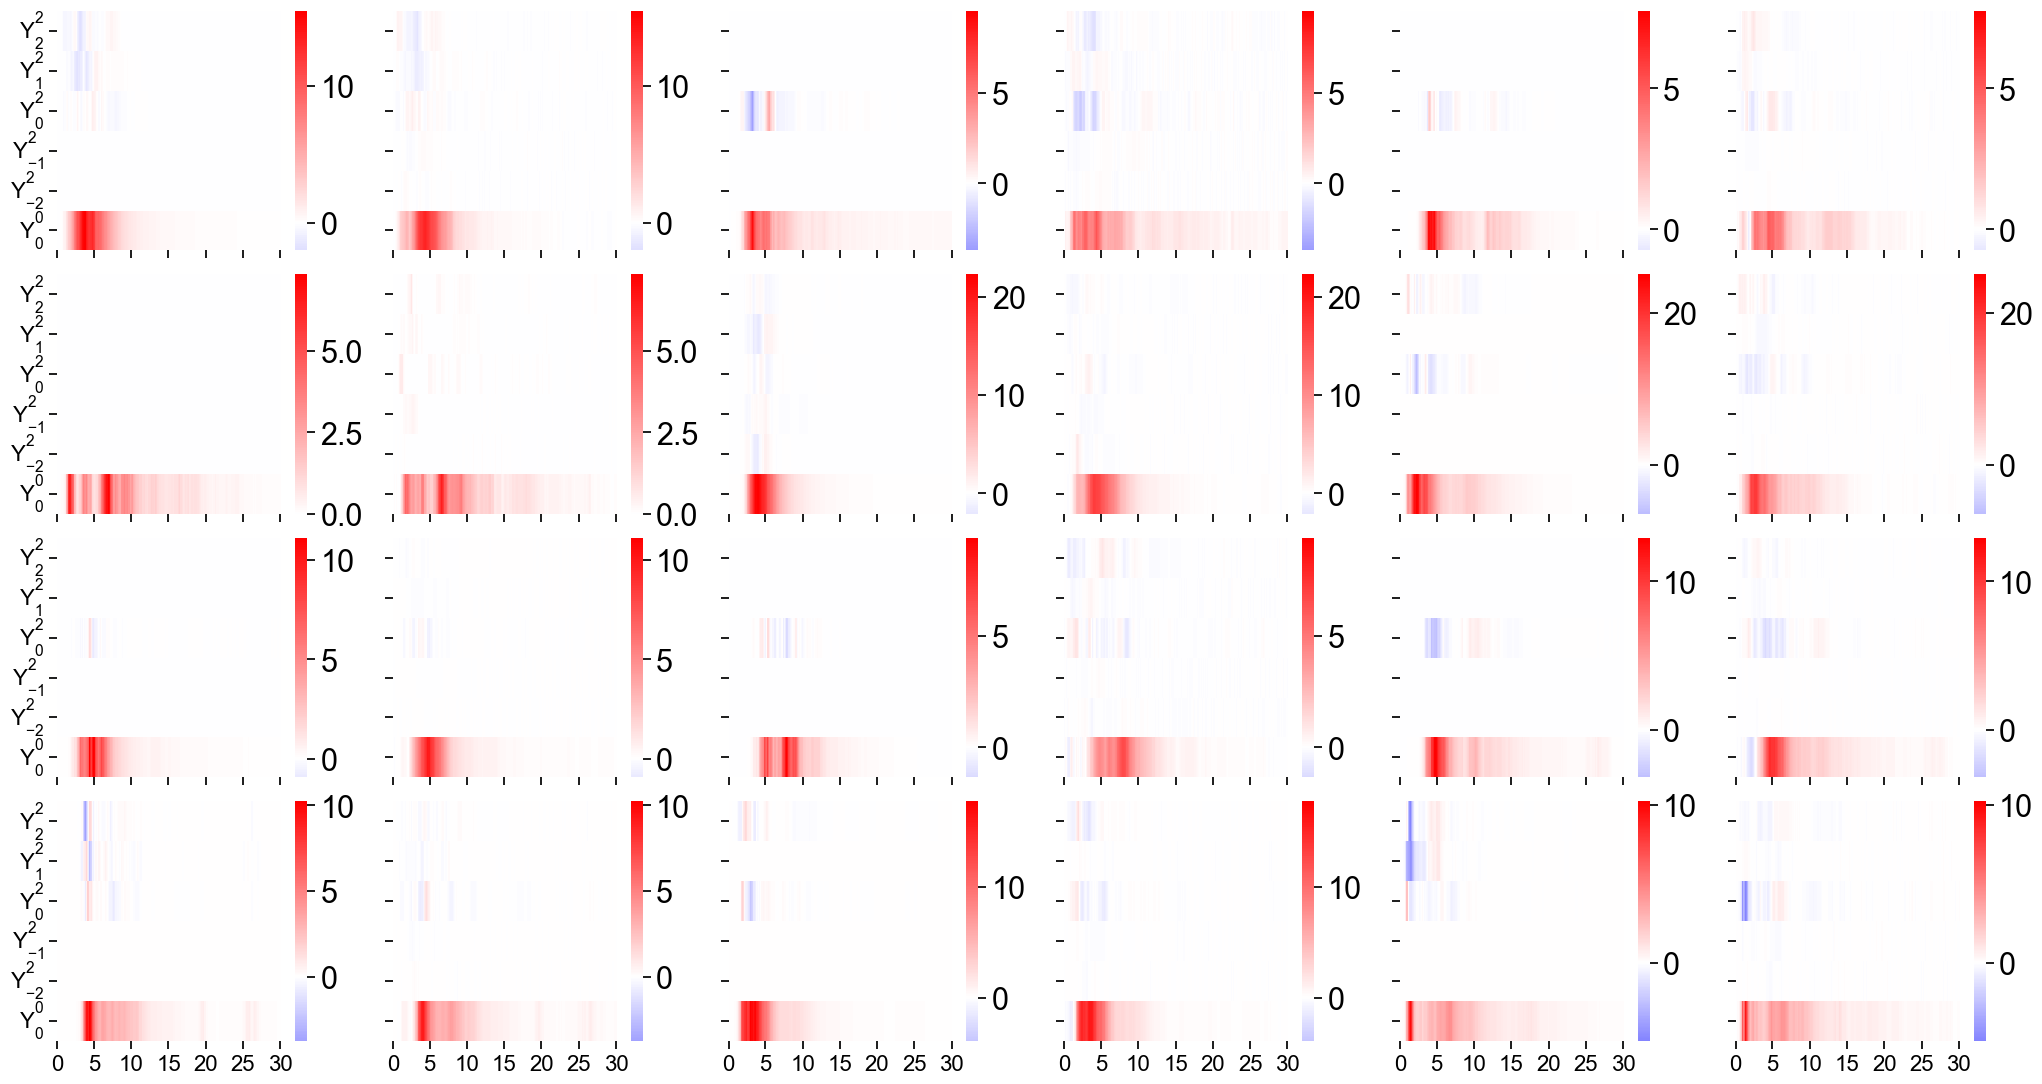

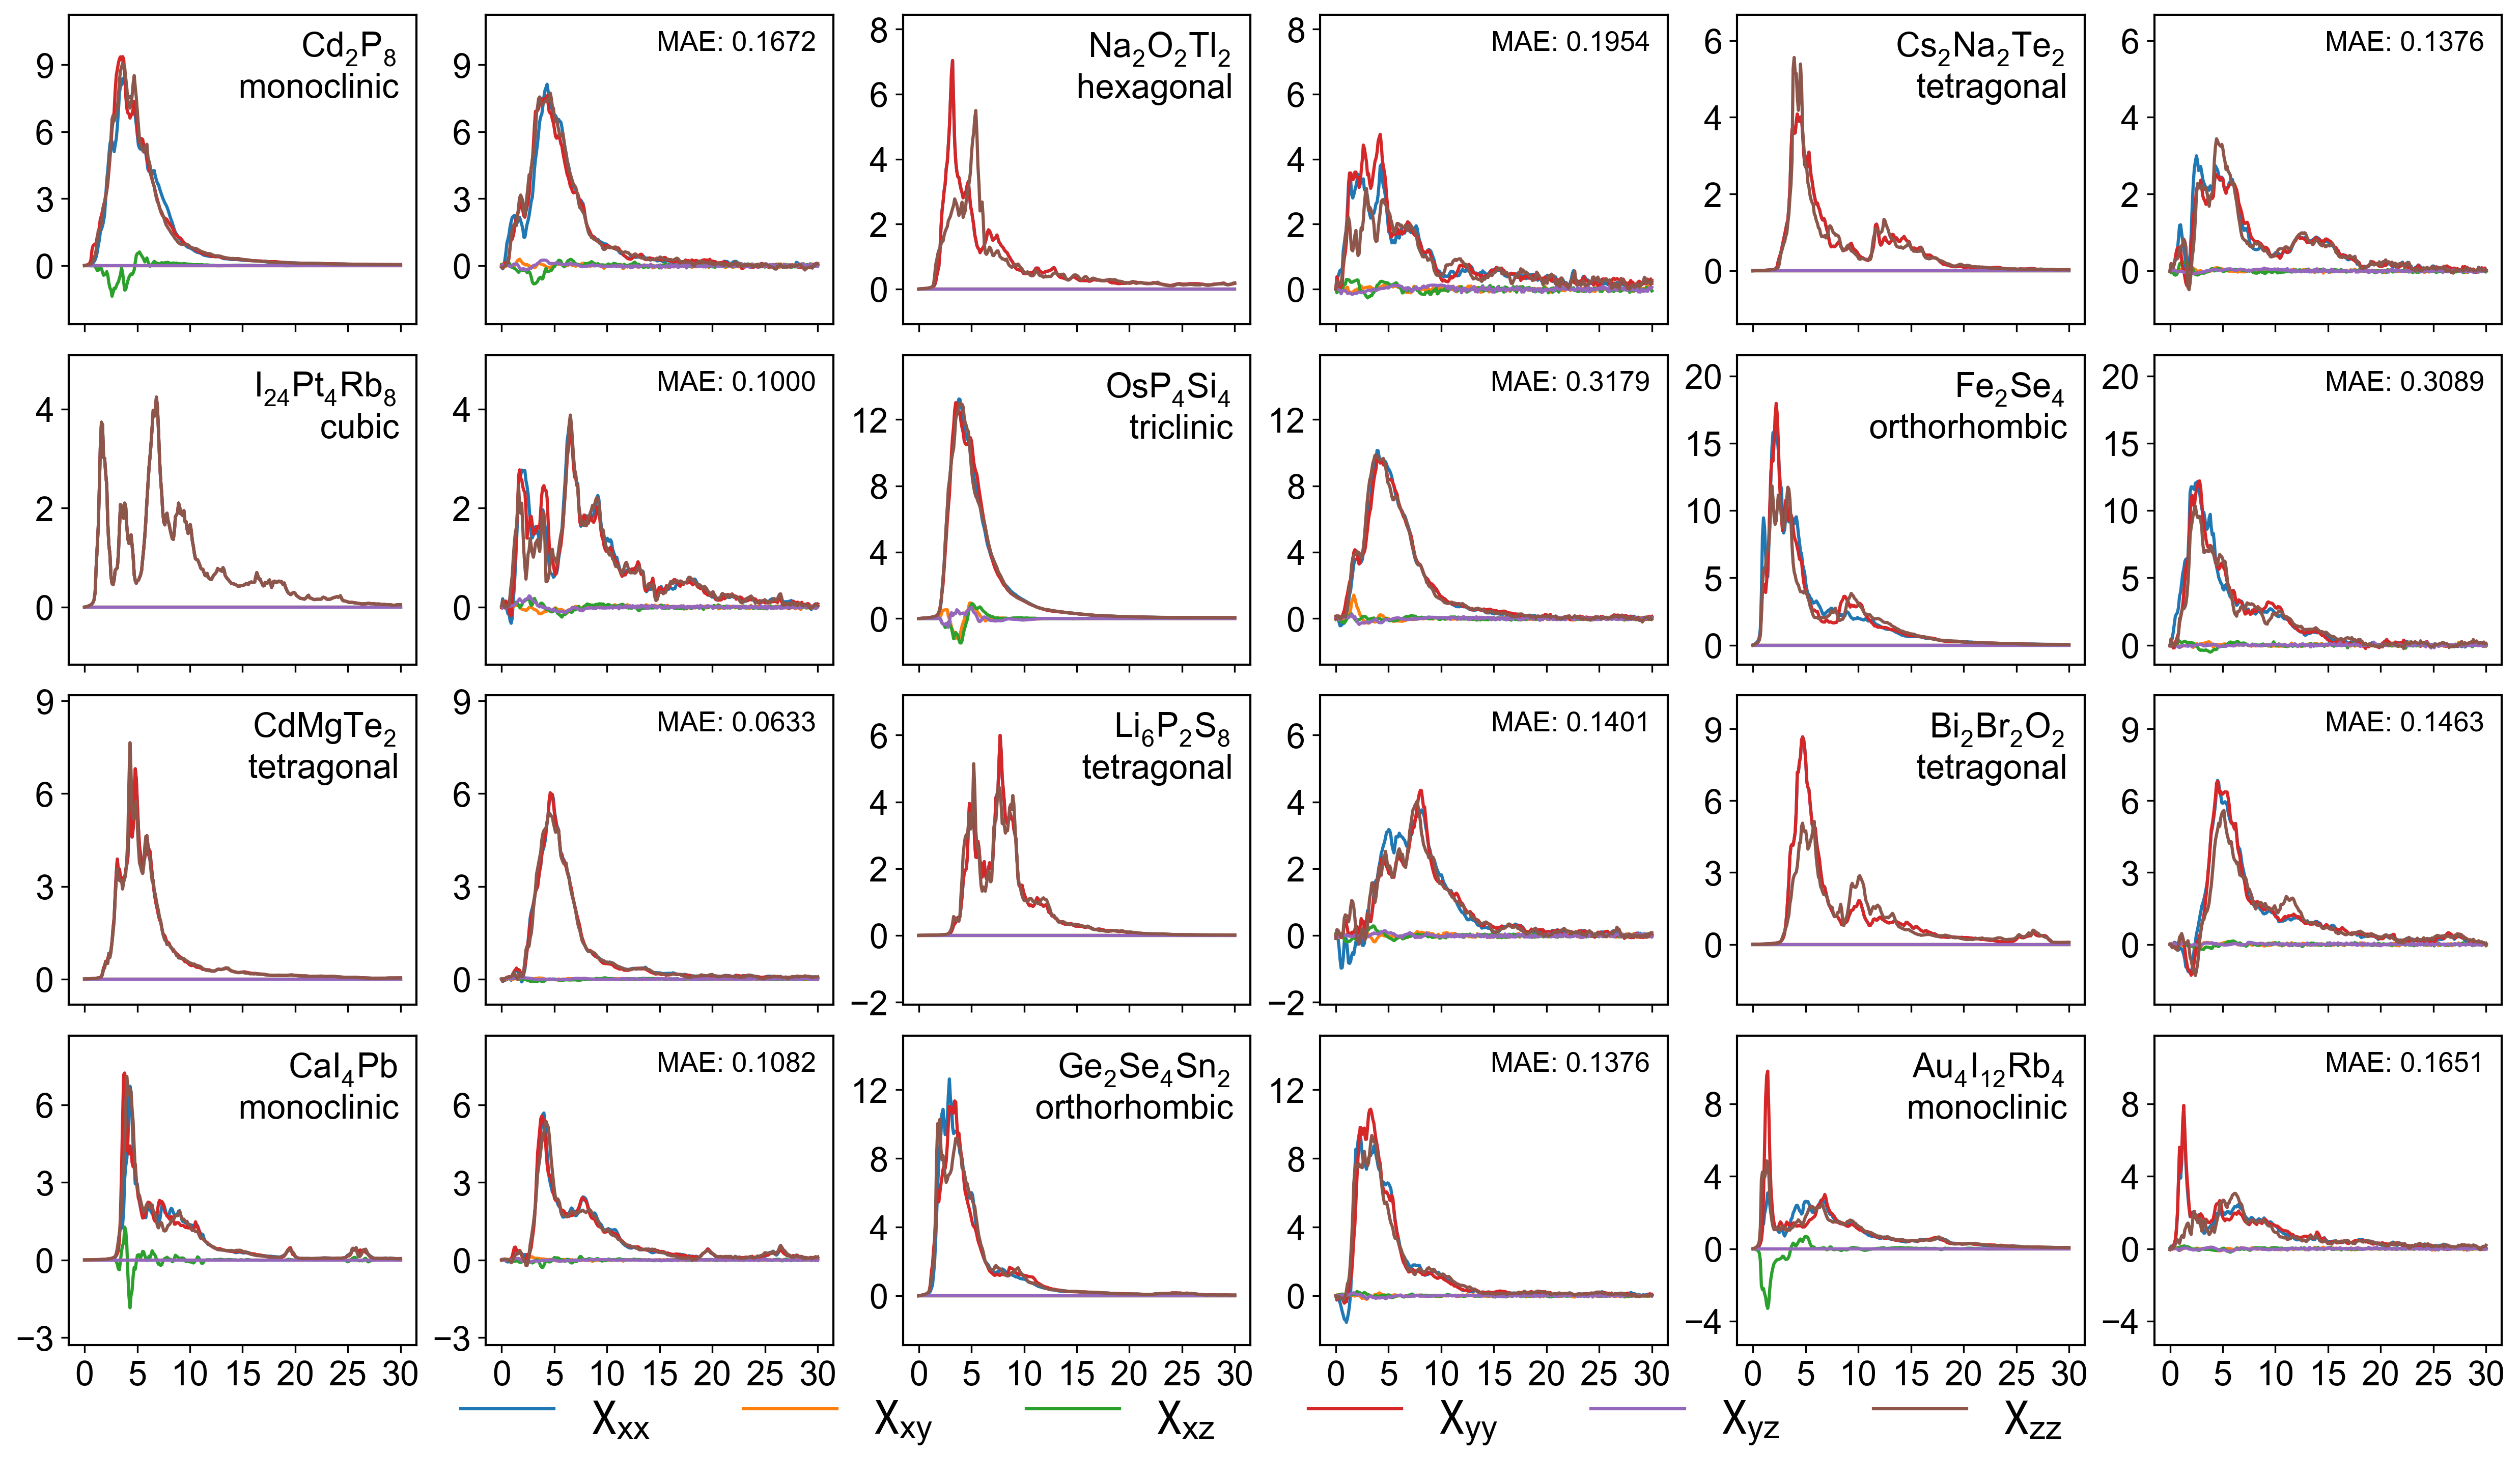

In [13]:
column = 'imag_Permittivity_Matrices_interp'

sph_tensors = torch.tensor(np.stack(df['y_pred_sph'].values))  
cart_tensors = x.to_cartesian(sph_tensors)
df['y_pred_cart'] = list(cart_tensors.numpy())  

cart_true = np.stack(df[column].values)  # Shape: (num_samples, 301, 3, 3)
cart_pred = np.stack(df['y_pred_cart'].values)  # Shape: (num_samples, 301, 3, 3)

# Convert to PyTorch tensors
cart_true_tensor = torch.tensor(cart_true, dtype=torch.float64)
cart_pred_tensor = torch.tensor(cart_pred, dtype=torch.float64)

# Define upper diagonal indices of symmetric 3x3 tensor
inds_diag = [(0, 0), (1, 1), (2, 2)]
inds_off = [(0, 1), (0, 2), (1, 2)]

# Compute symmetric-only MAE and MSE
def compute_symmetric_errors(pred, true):
    diffs = []
    for i, j in inds_diag + inds_off:
        diff = pred[:, :, i, j] - true[:, :, i, j]  # shape: (N, freq)
        diffs.append(diff)
    diffs = torch.stack(diffs, dim=0)  # shape: (6, N, freq)
    mse = torch.mean(diffs ** 2, dim=0)  # shape: (N, freq)
    mae = torch.mean(torch.abs(diffs), dim=0)  # shape: (N, freq)
    return mse, mae

# Compute and assign
mse_torch, mae_cart = compute_symmetric_errors(cart_pred_tensor, cart_true_tensor)
mse_torch = mse_torch.cpu().numpy()  # shape: (N, freq)
mae_cart = mae_cart.cpu().numpy()    # shape: (N, freq)

sph_true = np.stack(df['sph_coefs'].values)  # Shape: (num_samples, 301, 3, 3)
sph_pred = np.stack(df['y_pred_sph'].values)  # Shape: (num_samples, 301, 3, 3)
# Convert to PyTorch tensors

sph_true_tensor = torch.tensor(sph_true, dtype=torch.float64)
sph_pred_tensor = torch.tensor(sph_pred, dtype=torch.float64)


# Store the MSE values in the DataFrame
df['mse_cart'] = np.mean(mse_torch, axis=1)
df['mae_cart'] = np.mean(mae_cart, axis=1)
mae_sph = torch.mean(torch.abs(sph_pred_tensor - sph_true_tensor), dim=(1, 2)).cpu().numpy() 
df['mae_sph'] = mae_sph

mae_sph_mean = df['mae_sph'].mean()
mae_sph_std = df['mae_sph'].std()
mae_cart_mean = df['mae_cart'].mean()
mae_cart_std = df['mae_cart'].std()

def get_random_sample_indices(idx, n):
    """Returns `n` randomly selected unique indices from `idx`."""
    if len(idx) < n:
        n = len(idx)  # Ensure we don't exceed available samples
    return np.random.choice(idx, size=n, replace=False)

n_samples = 12  # Adjust as needed

random_idx_train = get_random_sample_indices(idx_train, n_samples)
random_idx_valid = get_random_sample_indices(idx_valid, n_samples)
random_idx_test = get_random_sample_indices(idx_test, n_samples)

# Use the same indices for both functions
# plot_spherical_harmonics_comparison(df, random_idx_train, column, title_prefix="training_set", n=n_samples)
# plot_spherical_harmonics_comparison(df, random_idx_valid, column, title_prefix="validation_set", n=n_samples)
plot_spherical_harmonics_comparison(df, random_idx_test, column, title_prefix="testing_set", n=n_samples)


# plot_cartesian_tensor_comparison(df, random_idx_train, column, title_prefix="training_set", n=n_samples)
# plot_cartesian_tensor_comparison(df, random_idx_valid, column, title_prefix="validation_set", n=n_samples)
plot_cartesian_tensor_comparison(df, random_idx_test, column, title_prefix="testing_set", n=n_samples)